In [115]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

gitpath=os.path.expanduser("~/git/cshlwork")
sys.path.append(gitpath)

from cshlwork.utils import JobRunner, JobStack, JobSet
# for processing initial fastq
from mapseq.core import get_default_config, load_sample_info, load_barcodes, trim_fasta 
from mapseq.core import process_fastq_pair, make_summaries

# for processing barcode-specific fasta files
from cshlwork.utils import dataframe_to_seqlist, write_fasta_from_df, run_command_shell, NonZeroReturnException, setup_logging
from alignment.bowtie import run_bowtie, make_bowtie_df

# for bowtie
from alignment.bowtie import run_bowtie, make_bowtie_df, matrix_df_from_btdf
# Setup paths for analysis
cp = get_default_config()
sampleinfo = os.path.expanduser('~/project/mapseq/M205test/Mseq205_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M205test/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M205testout')
infiles = [
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R2_001.fastq.gz')
          ]
#logging.getLogger().setLevel(logging.DEBUG)   
logging.getLogger().setLevel(logging.INFO)
print("Done")

Done


In [116]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
sampdf

26


,usertube,ourtube,samplename,siteinfo,rtprimer,brain,col_num
1,OB,1,Olfactory Bulb,NaN,1,YW143,1
2,ACB,2,ACB,NaN,2,YW143,2
3,AI,3,AI,NaN,3,YW143,3
4,CP,4,CP (dorsal part - can just dissect out the top...,NaN,4,YW143,4
5,MTN,5,MTN,NaN,5,YW143,5
6,BLAa,6,BLAa,NaN,6,YW143,6
7,PIR,7,Piriform Cortex,NaN,7,YW143,7
8,VTA,8,VTA,NaN,8,YW143,8
9,TeA,9,TeA,NaN,9,YW143,9
10,ENTl,10,ENTl,NaN,10,YW143,10


In [123]:
# handle all the input. usually takes ~25 minutes
process_fastq_pair(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
!ls ~/project/mapseq/M205testout/

2023-03-07 14:34:52,959 (UTC) [ INFO ] core.py:420 root.check_output(): all output exists.
2023-03-07 14:34:52,960 (UTC) [ INFO ] core.py:431 root.process_fastq_pair(): output_exists=True force=False
2023-03-07 14:34:52,962 (UTC) [ INFO ] core.py:501 root.process_fastq_pair(): all output exists and force=False. Not recalculating.


0mm             BC14.fasta      BC2.fasta       BC25.fasta      BC7.fasta
1mm             BC14.tsv        BC2.tsv         BC25.tsv        BC7.tsv
BC1.fasta       BC15.fasta      BC20.fasta      BC26.fasta      BC8.fasta
BC1.tsv         BC15.tsv        BC20.tsv        BC26.tsv        BC8.tsv
BC10.fasta      BC16.fasta      BC21.fasta      BC3.fasta       BC9.fasta
BC10.tsv        BC16.tsv        BC21.tsv        BC3.tsv         BC9.tsv
BC11.fasta      BC17.fasta      BC22.fasta      BC4.fasta       indexes
BC11.tsv        BC17.tsv        BC22.tsv        BC4.tsv         paired.txt
BC12.fasta      BC18.fasta      BC23.fasta      BC5.fasta       sampleinfo.tsv
BC12.tsv        BC18.tsv        BC23.tsv        BC5.tsv         unmatched.fasta
BC13.fasta      BC19.fasta      BC24.fasta      BC6.fasta
BC13.tsv        BC19.tsv        BC24.tsv        BC6.tsv


In [124]:
dflist = []
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    df = make_counts_df(cp, bch.filename, bclabel=bch.label)
    bch.dataframe = df
    df.to_csv(of, sep='\t')
    dflist.append(df)
alldf = BarCodeHandler.merge_counts(cp, dflist)
#alldf = threshold_counts(cp, alldf)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-03-07 14:34:56,362 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 7341 non-'N' sequences out of 7342
2023-03-07 14:34:58,472 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 160425 non-'N' sequences out of 160429
2023-03-07 14:34:59,816 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 32485 non-'N' sequences out of 32485
2023-03-07 14:35:05,489 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 603075 non-'N' sequences out of 603096
2023-03-07 14:35:10,089 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 238904 non-'N' sequences out of 238914
2023-03-07 14:35:11,689 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 108676 non-'N' sequences out of 108678
2023-03-07 14:35:12,048 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 2820 non-'N' sequences out of 2820
2023-03-07 14:35:12,878 (UTC) [ INFO ] core.py:146 root.make_counts_df(): kept 94041 non-'N' sequences out of 94042
2023-03-07 14:35:13,393 (UTC) [ INFO ] core.py:146 root.make_counts_

,bc_label,sequence,counts,logcounts
0,BC1,GCTTTACTAAACTCTTCCTTGCCATTGAATTCACCCTGCGCACG,8,2.079442
1,BC1,AACACCAGCAAGTGGAGGGTTATGCGCGTACTCCTATACAACAA,7,1.945910
2,BC1,ATTCTCAGGTAAATGGCGCCGCTTAATTTATCGACTAATAGGGA,7,1.945910
3,BC1,GTTTCACCCGGTCTGCACGCGCCAGCCACCCGATAAGGCATTCT,6,1.791759
4,BC1,CTGGAGCTGCGATGTCGTTAACGCCGTCAGTCATATTTACTAAA,6,1.791759
...,...,...,...,...
8516376,BC26,GCCAGCGAGAGTGGTTCAGAATTACGTCAGTCTTTGGATTATCG,1,0.000000
8516377,BC26,ACCAAGGGGGGATGCGCAAAGGGACGTCAGTCAGAATCACCGCG,1,0.000000
8516378,BC26,ATATTGCAGTTATCTACCTAAGTTAACGAATTGGCACATTGCTA,1,0.000000
8516379,BC26,CTGAACAGGTGGGTCTCGTACCGGCGTCAGTCGAATGGTCTAAT,1,0.000000


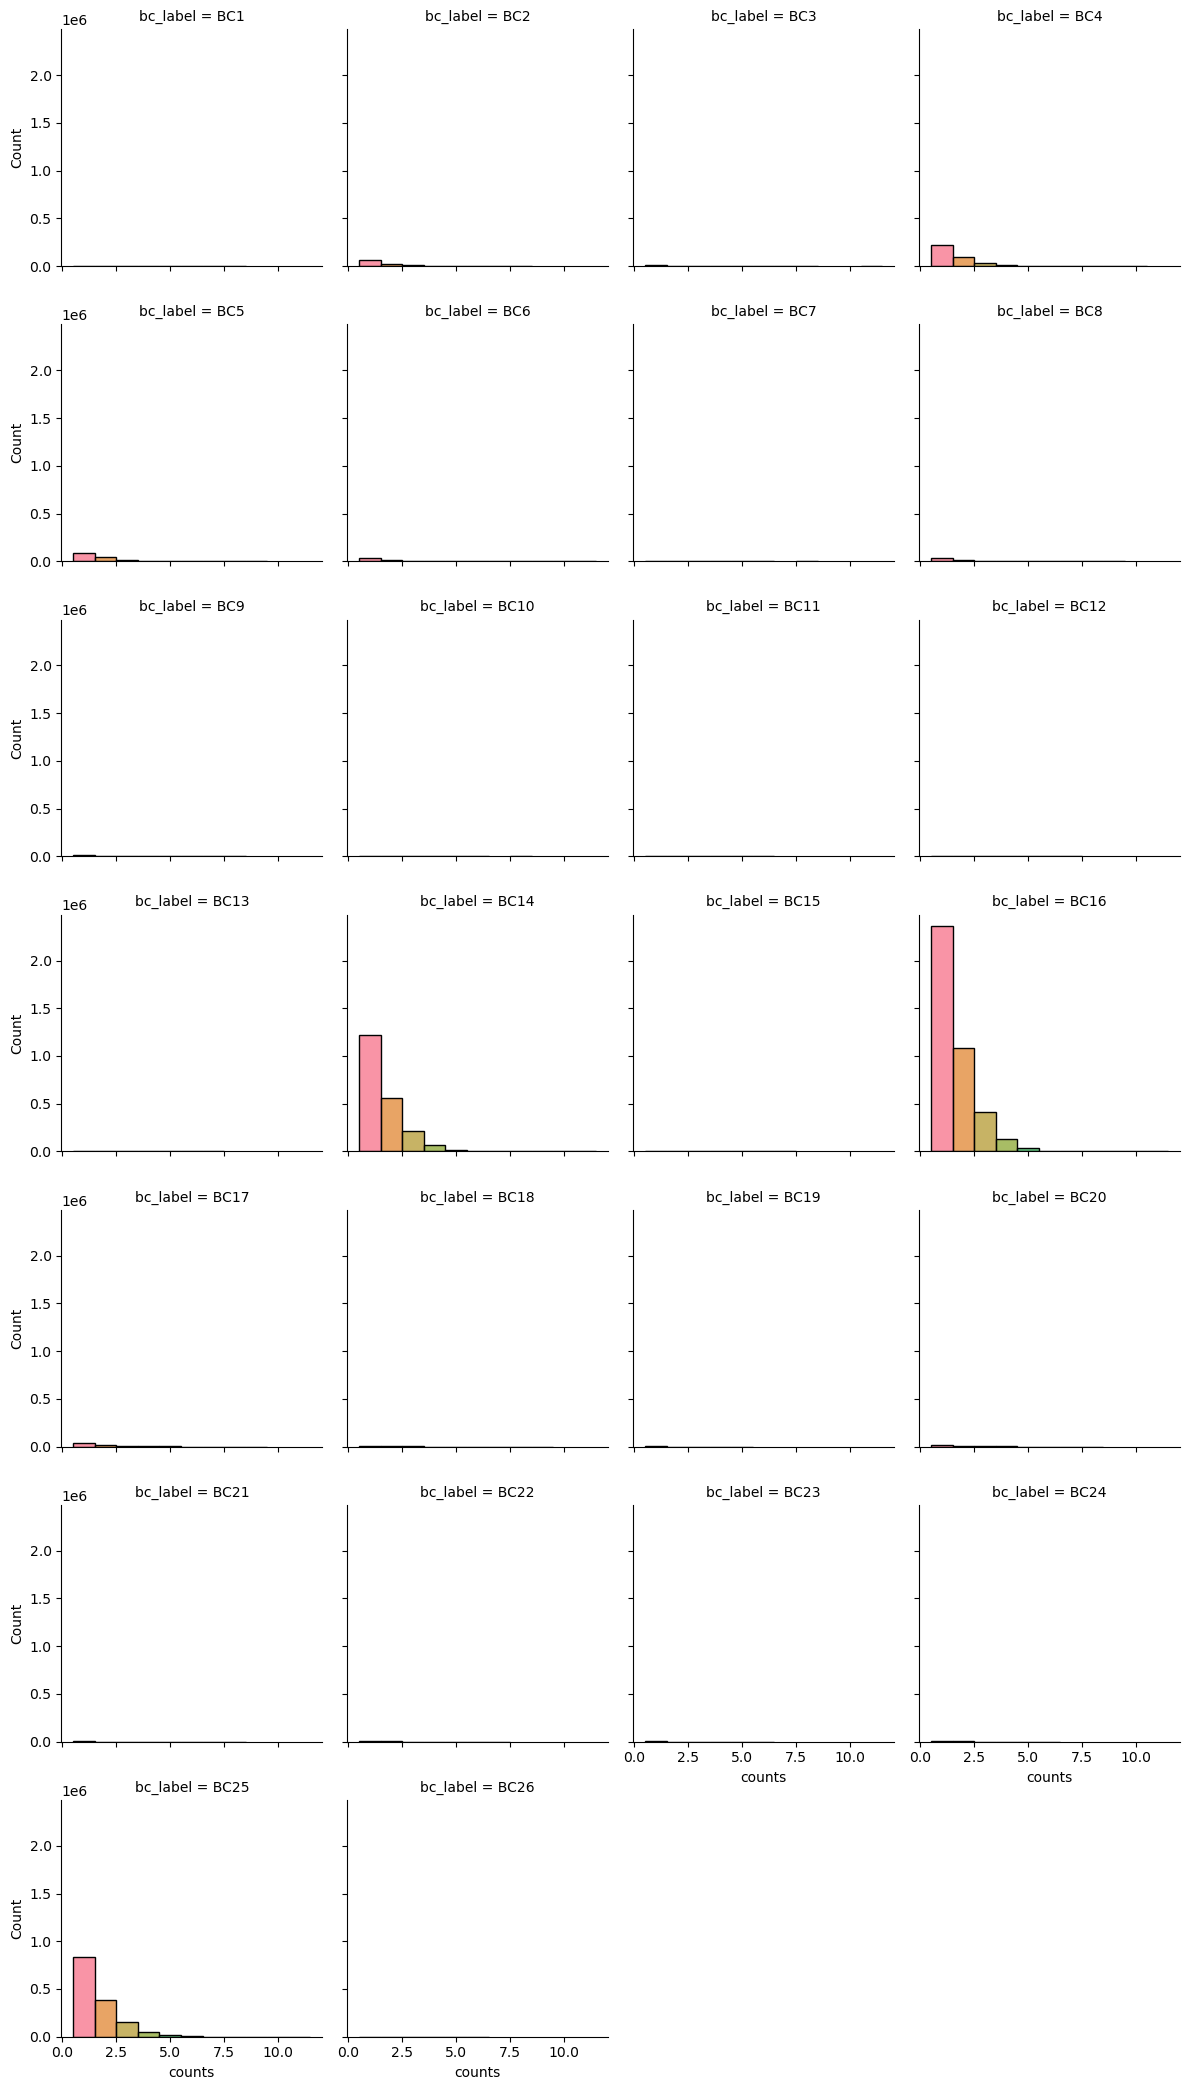

In [120]:
graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
graph.map(sns.histplot, "counts")
plt.show()

In [104]:
# use last label  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

for bch in bcolist:
    outfile = trim_fasta(cp, bch.filename, length=32)
    df = make_counts_df(cp, outfile, bclabel=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)
    reals.append(realdf)
    spikes.append(spikedf)
    lones.append(lonedf)
    spikedf.to_csv(f'{outdir}/{bch.label}.spike.tsv')
    realdf.to_csv(f'{outdir}/{bch.label}.real.tsv')
    lonedf.to_csv(f'{outdir}/{bch.label}.lone.tsv')

print(reals[0])
    

2023-03-04 16:33:56,346 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 8852 to /Users/jhover/project/mapseq/M205testout/BC1.32.fasta
2023-03-04 16:33:56,421 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 8852 non-'N' sequences out of 8852
2023-03-04 16:33:56,433 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=319 spikeins=9 real=149 lone=130


BC1 319


2023-03-04 16:33:56,753 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 9538 to /Users/jhover/project/mapseq/M205testout/BC2.32.fasta
2023-03-04 16:33:56,836 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 9538 non-'N' sequences out of 9538
2023-03-04 16:33:56,847 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=379 spikeins=14 real=147 lone=164
2023-03-04 16:33:56,956 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 7646 to /Users/jhover/project/mapseq/M205testout/BC3.32.fasta
2023-03-04 16:33:57,020 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 7646 non-'N' sequences out of 7646
2023-03-04 16:33:57,031 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=341 spikeins=25 real=157 lone=95


BC2 379
BC3 341


2023-03-04 16:33:57,092 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3963 to /Users/jhover/project/mapseq/M205testout/BC4.32.fasta
2023-03-04 16:33:57,126 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3963 non-'N' sequences out of 3963
2023-03-04 16:33:57,136 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=260 spikeins=21 real=104 lone=111
2023-03-04 16:33:57,185 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3085 to /Users/jhover/project/mapseq/M205testout/BC5.32.fasta
2023-03-04 16:33:57,213 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3085 non-'N' sequences out of 3085
2023-03-04 16:33:57,222 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=239 spikeins=9 real=111 lone=88


BC4 260
BC5 239


2023-03-04 16:33:57,786 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 27220 to /Users/jhover/project/mapseq/M205testout/BC6.32.fasta
2023-03-04 16:33:58,016 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 27220 non-'N' sequences out of 27220
2023-03-04 16:33:58,036 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=997 spikeins=40 real=490 lone=284
2023-03-04 16:33:58,067 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 1742 to /Users/jhover/project/mapseq/M205testout/BC7.32.fasta
2023-03-04 16:33:58,083 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 1742 non-'N' sequences out of 1742
2023-03-04 16:33:58,092 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=150 spikeins=3 real=73 lone=53
2023-03-04 16:33:58,135 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 2756 to /Users/jhover/project/mapseq/M205testout/BC8.32.fasta
2023-03-04 16:33:58,160 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 2756 non-'N' se

BC6 997
BC7 150
BC8 212


2023-03-04 16:33:58,491 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 9514 to /Users/jhover/project/mapseq/M205testout/BC9.32.fasta
2023-03-04 16:33:58,573 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 9514 non-'N' sequences out of 9514
2023-03-04 16:33:58,585 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=376 spikeins=17 real=219 lone=97
2023-03-04 16:33:58,641 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3330 to /Users/jhover/project/mapseq/M205testout/BC10.32.fasta
2023-03-04 16:33:58,670 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3330 non-'N' sequences out of 3330
2023-03-04 16:33:58,681 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=284 spikeins=15 real=110 lone=134
2023-03-04 16:33:58,742 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3783 to /Users/jhover/project/mapseq/M205testout/BC11.32.fasta
2023-03-04 16:33:58,774 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3783 non-'N' s

BC9 376
BC10 284
BC11 325


2023-03-04 16:33:58,950 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 11309 to /Users/jhover/project/mapseq/M205testout/BC12.32.fasta
2023-03-04 16:33:59,045 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 11309 non-'N' sequences out of 11309
2023-03-04 16:33:59,058 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=371 spikeins=11 real=236 lone=85
2023-03-04 16:33:59,103 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 2862 to /Users/jhover/project/mapseq/M205testout/BC13.32.fasta
2023-03-04 16:33:59,128 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 2862 non-'N' sequences out of 2862
2023-03-04 16:33:59,137 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=237 spikeins=14 real=125 lone=70


BC12 371
BC13 237


2023-03-04 16:33:59,567 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 18599 to /Users/jhover/project/mapseq/M205testout/BC14.32.fasta
2023-03-04 16:33:59,726 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 18599 non-'N' sequences out of 18599
2023-03-04 16:33:59,741 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=345 spikeins=8 real=264 lone=51


BC14 345


2023-03-04 16:34:00,272 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 24212 to /Users/jhover/project/mapseq/M205testout/BC15.32.fasta
2023-03-04 16:34:00,474 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 24212 non-'N' sequences out of 24212
2023-03-04 16:34:00,494 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=1220 spikeins=34 real=623 lone=423
2023-03-04 16:34:00,608 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 7937 to /Users/jhover/project/mapseq/M205testout/BC16.32.fasta
2023-03-04 16:34:00,676 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 7937 non-'N' sequences out of 7937


BC15 1220
BC16 405


2023-03-04 16:34:00,687 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=405 spikeins=25 real=226 lone=114
2023-03-04 16:34:00,810 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 8619 to /Users/jhover/project/mapseq/M205testout/BC17.32.fasta
2023-03-04 16:34:00,883 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 8619 non-'N' sequences out of 8619
2023-03-04 16:34:00,895 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=295 spikeins=8 real=164 lone=92


BC17 295


2023-03-04 16:34:01,194 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 9489 to /Users/jhover/project/mapseq/M205testout/BC18.32.fasta
2023-03-04 16:34:01,275 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 9489 non-'N' sequences out of 9489
2023-03-04 16:34:01,286 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=245 spikeins=14 real=130 lone=72
2023-03-04 16:34:01,340 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3701 to /Users/jhover/project/mapseq/M205testout/BC19.32.fasta
2023-03-04 16:34:01,373 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3701 non-'N' sequences out of 3701
2023-03-04 16:34:01,382 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=244 spikeins=5 real=127 lone=87
2023-03-04 16:34:01,473 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 6469 to /Users/jhover/project/mapseq/M205testout/BC20.32.fasta


BC18 245
BC19 244


2023-03-04 16:34:01,530 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 6469 non-'N' sequences out of 6469
2023-03-04 16:34:01,541 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=204 spikeins=8 real=84 lone=90
2023-03-04 16:34:01,648 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 7475 to /Users/jhover/project/mapseq/M205testout/BC21.32.fasta
2023-03-04 16:34:01,711 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 7475 non-'N' sequences out of 7475
2023-03-04 16:34:01,722 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=322 spikeins=18 real=210 lone=65


BC20 204
BC21 322


2023-03-04 16:34:01,762 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 2412 to /Users/jhover/project/mapseq/M205testout/BC22.32.fasta
2023-03-04 16:34:01,783 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 2412 non-'N' sequences out of 2412
2023-03-04 16:34:01,793 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=262 spikeins=6 real=110 lone=132
2023-03-04 16:34:01,838 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 2915 to /Users/jhover/project/mapseq/M205testout/BC23.32.fasta
2023-03-04 16:34:01,864 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 2915 non-'N' sequences out of 2915
2023-03-04 16:34:01,874 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=166 spikeins=5 real=93 lone=54


BC22 262
BC23 166


2023-03-04 16:34:02,089 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 3234 to /Users/jhover/project/mapseq/M205testout/BC24.32.fasta
2023-03-04 16:34:02,118 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 3234 non-'N' sequences out of 3234
2023-03-04 16:34:02,128 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=224 spikeins=17 real=89 lone=84
2023-03-04 16:34:02,304 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 12896 to /Users/jhover/project/mapseq/M205testout/BC25.32.fasta


BC24 224


2023-03-04 16:34:02,412 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 12896 non-'N' sequences out of 12896
2023-03-04 16:34:02,427 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=461 spikeins=8 real=273 lone=123
2023-03-04 16:34:02,545 (UTC) [ INFO ] core.py:164 root.trim_fasta(): wrote 8374 to /Users/jhover/project/mapseq/M205testout/BC26.32.fasta
2023-03-04 16:34:02,617 (UTC) [ INFO ] core.py:132 root.make_counts_df(): kept 8374 non-'N' sequences out of 8374


BC25 461
BC26 479


2023-03-04 16:34:02,630 (UTC) [ INFO ] core.py:215 root.split_spike_real_lone_barcodes(): initial=479 spikeins=29 real=246 lone=155


                             sequence  counts bc_label
0    CTACAGGTTCTTATGAGGACGGGACTTGTGTC    4431      BC1
1    AAAATAACCACTTTCGATCTCTATGAGGACTT     691      BC1
2    ATAGCGGGCCACATGAGGACAGGAGCCCGGCT     448      BC1
3    CTGCTCCAAGAGATGAGGACGTTCCGCACATC     387      BC1
5    TGTCTCGTCAGCAGTGCTTATGAGGACACCCT     168      BC1
..                                ...     ...      ...
305  AAAATAACCACTTTCGATCACTATGAGGACTT       1      BC1
306  AGAATGAGGACCTTCGCCCGCATTATCCCATT       1      BC1
310  TGTCTCGTAAGCAGTGCTTATGAGGACACCCT       1      BC1
317  CGTAGACATGAGGACTTTCATGAAGATCTATC       1      BC1
318  GAATGAGGACAACACCTTTCTCCGTCGTTCTC       1      BC1

[149 rows x 3 columns]


In [127]:
bch = bcolist[15]
print(bch.label)
base = 'BC16'
aligner = cp.get('bcfasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

2023-03-07 14:44:18,388 (UTC) [ INFO ] utils.py:632 root.dataframe_to_seqlist(): made list of 246 SeqRecords
2023-03-07 14:44:18,391 (UTC) [ INFO ] bowtie.py:35 root.run_bowtie(): running allxall bowtie on /Users/jhover/project/mapseq/M205testout/BC16.real.seq.fasta -> /Users/jhover/project/mapseq/M205testout/BC16.real.bowtie


BC16


2023-03-07 14:44:18,749 (UTC) [ INFO ] bowtie.py:67 root.run_bowtie(): bowtie-build done.
2023-03-07 14:44:19,031 (UTC) [ INFO ] bowtie.py:103 root.run_bowtie(): bowtie done.


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,TTTTAGGCAATAATGGTTGATACCCGTTCATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,449,0,TTTTAGGCAATAATGGTTGATACCCGTTCATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,11:G>A
2,0,+,217,0,TTTTAGGCAATAATGGTTGATACCCGTTCATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,14:T>G
3,0,+,467,0,TTTTAGGCAATAATGGTTGATACCCGTTCATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,0:G>T
4,0,+,325,0,TTTTAGGCAATAATGGTTGATACCCGTTCATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,15:A>G
...,...,...,...,...,...,...,...,...
689,474,+,359,0,TTAGGCACTAAGTCAGTATGTCTCTTAGGGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,"16:C>T,19:C>G"
690,474,+,312,0,TTAGGCACTAAGTCAGTATGTCTCTTAGGGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,"16:C>T,29:A>G"
691,474,+,405,0,TTAGGCACTAAGTCAGTATGTCTCTTAGGGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,"16:C>T,23:A>C"
692,474,+,388,0,TTAGGCACTAAGTCAGTATGTCTCTTAGGGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,"14:G>A,16:C>T"
